In [2]:
#import everything here
import vireoSNP
import numpy as np
import pandas as pd

from scipy import sparse
from scipy.io import mmread
from scipy.io import mmwrite
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib as mpl
from vireoSNP import BinomMixtureVB
import seaborn as sns

from mquad.mquad_utils import findKnee, plot_confusionMatrix, confusionMatrix

print(vireoSNP.__version__)
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

0.5.6


In [3]:
mquad_AD = mmread('data/mquad/passed_ad.mtx').tocsc()
mquad_DP = mmread('data/mquad/passed_dp.mtx').tocsc()

mquad_AD.shape, mquad_DP.shape

((24, 5220), (24, 5220))

In [35]:
#fit on mquad output
np.random.seed(42)
_model = BinomMixtureVB(n_var=len(mquad_AD.getnnz(axis=1)), n_cell=len(mquad_AD.getnnz(axis=0)), n_donor=5)
_model.fit(mquad_AD, mquad_DP, min_iter=30, n_init=300)

mquad_modelCA = _model

In [34]:
## how many cells are assignable?

a = np.sum(np.max(mquad_modelCA.ID_prob, axis=1) > 0.8)/5220

Precision = 0.522354005625381
Recall = 0.9479421070893247
Precision = 0.522354005625381
Recall = 0.9479421070893247


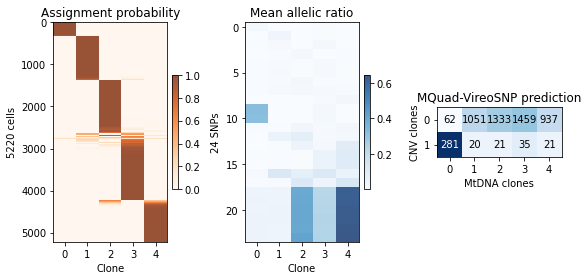

In [5]:
#assignment prob heatmap
fig = plt.figure(figsize=(8,4))

from vireoSNP.plot.base_plot import heat_matrix
plt.subplot(1,3,1)
im = heat_matrix(mquad_modelCA.ID_prob, cmap="Oranges", alpha=0.8,
                 display_value=False, row_sort=True, interpolation = 'none')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Assignment probability")
plt.xlabel("Clone")
plt.ylabel("%d cells" %(mquad_modelCA.n_cell))
plt.xticks(range(mquad_modelCA.n_donor))
plt.tight_layout()

plt.subplot(1,3,2)
AF_SNPs = mquad_modelCA.beta_mu
#rearrange clones to match fig 3b
#AF_SNPs_sorted = np.array([[i[1], i[2], i[0]]for i in AF_SNPs])
im = heat_matrix(AF_SNPs, cmap="Blues", alpha=0.8, 
                 display_value=False, row_sort=True, interpolation='none', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Mean allelic ratio")
plt.xlabel("Clone")
plt.ylabel("%d SNPs" %(mquad_modelCA.n_var))
plt.xticks(range(mquad_modelCA.n_donor))

#mquad confusion matrix
ax = plt.subplot(1,3,3)
clone_id = np.argmax(mquad_modelCA.ID_prob, axis=1)
mapping = pd.read_csv('/storage/yhhuang/research/mito/mkn45/CNV-analysis-MKN45/mixtureVB-VireoSNP-mkn45/cluster_results_chr24_clusters2&3_mkn45-fulldepth_VB.csv')
real_lab = mapping.sub24_2_r1

confusionMatrix(real_lab, clone_id)
confusion = confusionMatrix(real_lab, clone_id)
#confusion = confusion[["PDX mRCC", "Pt mRCC", "PDX pRCC"]]
res = plot_confusionMatrix(confusion, ax)
plt.title('MQuad-VireoSNP prediction')
plt.ylabel('CNV clones')
plt.xlabel('MtDNA clones')
plt.xticks(range(5), confusion.columns)
plt.yticks(range(len(confusion)), confusion.index)
plt.tight_layout()

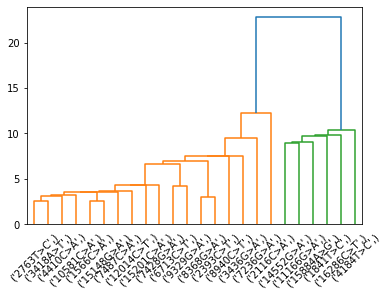

In [6]:
variants = pd.read_table('data/mquad/passed_variant_names.txt', header=None)
AF_df = pd.DataFrame(mquad_AD/mquad_DP, index=variants).fillna(0)

## perform hclust on rows instead of using snsclustermap cuz its slow af

from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list

linked = linkage(AF_df, 'single')
plt.subplot(1,1,1)
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            labels=AF_df.index,
            show_leaf_counts=True)
plt.show()

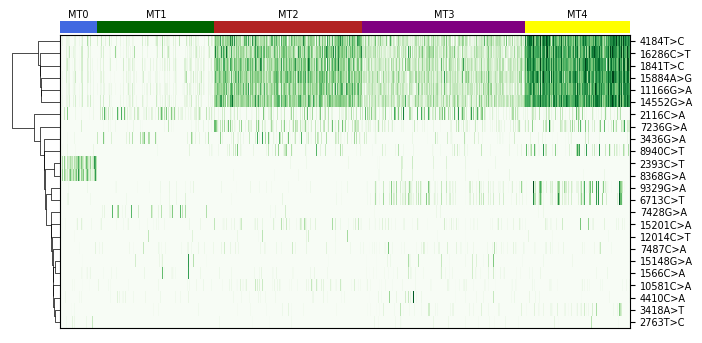

In [87]:
## AF matrix

row_idx = leaves_list(linked)
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(8,4))
ax=plt.subplot(111)
res = ax.imshow(AF_df.iloc[row_idx, np.argsort(clone_id)], cmap='Greens', aspect='auto', interpolation='none')
ax.axes.xaxis.set_visible(False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.yticks(range(len(AF_df)), variants.iloc[row_idx][0], fontsize=7)
divider = make_axes_locatable(ax)
left_ax = divider.append_axes("left", size=0.5, pad=0)
top_ax = divider.append_axes("top", size=0.13, pad=0.02, sharex=ax)

#ax_t = fig.add_axes([0.026,0.07,0.07,0.55], frame_on=False)
with plt.rc_context({'lines.linewidth': 0.5}):
    d = dendrogram(linked, ax=left_ax, orientation='left', no_labels=True, color_threshold=0, link_color_func=lambda x: 'k')
left_ax.invert_yaxis()
left_ax.axis('off')

#top_ax = fig.add_axes([0.095, 0.65, 0.38, 0.03], frame_on=False)
#dont change label num
LEFT = 0
iicolor = 0
c_names = ['MT0', 'MT1', 'MT2', 'MT3', 'MT4']
label_num=np.bincount(clone_id)
clone_pal = ['royalblue', 'darkgreen', 'firebrick', 'purple', 'yellow']
for num in label_num:
        top_ax.barh(0,num+1,left=LEFT,color=clone_pal[iicolor])
        top_ax.text(x=LEFT + num/2, y=0.8, s=c_names[iicolor], va='center', ha='center')
        top_ax.set_xlim(0,5220)
        top_ax.axis('off')
        LEFT += num
        iicolor += 1

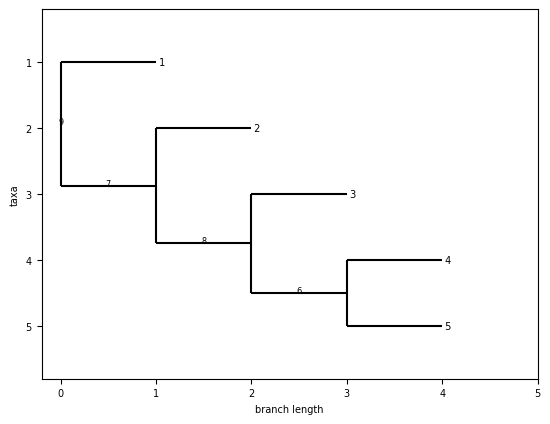

In [120]:
from Bio import Phylo

tree = Phylo.read('data/SCITE/SCITE_ml0.newick', 'newick')
Phylo.draw(tree)

In [110]:
sorted_df = AF_df.iloc[row_idx, np.argsort(clone_id)].T.reset_index(drop=True).T

i = 0
dict = {}
LEFT=0
for num in label_num:
    print("i, num, left = ", i, num, LEFT)
    dict['MT'+str(i)] = sorted_df.loc[:,LEFT:LEFT+num].mean(axis=1)
    print(dict['MT'+str(i)].shape)
    LEFT += num
    i += 1

grouped = pd.DataFrame.from_dict(dict)
genotype = grouped.apply(lambda x: pd.cut(x, bins=[0, 0.01, 0.9, 1, 5], labels=['0', '1', '2', '3'], include_lowest=True))

genotype.to_csv('genotype_matrix.csv', sep= ' ', header=False, index=False)

i, num, left =  0 343 0
(24,)
i, num, left =  1 1071 343
(24,)
i, num, left =  2 1354 1414
(24,)
i, num, left =  3 1494 2768
(24,)
i, num, left =  4 958 4262
(24,)


In [50]:
downsample_paths = [
    'data/compare/cellsnp_half_depth/',
    'data/compare/cellsnp_third_depth/',
    'data/compare/cellsnp_quarter_depth/',
    'data/compare/cellsnp_sixth_depth/'
]

silver_standard = pd.read_csv('data/mquad/BIC_params.csv')
silver_standard_variants = silver_standard.variant_name[(silver_standard.PASS_KP == True) & (silver_standard.PASS_MINCELLS == True)]

n_var, assignable, clonal_assignment_concordance = [], [], []

from utils import *
import scipy



for p in downsample_paths:
    df = pd.read_csv(p + 'mquad/BIC_params.csv')
    AD, DP, AF = load_vcf_data(p + 'cellSNP.cells.vcf.gz')
    detected = df.variant_name[(df.PASS_KP == True) & (df.PASS_MINCELLS == True)]
    #find n_variants matching with silver_standard
    prop_match = len(set(detected) & set(silver_standard_variants))/len(set(silver_standard_variants))
    n_var.append(prop_match)
    print("Prop of informative variants recovered: ", prop_match)
    mquad_AD = scipy.sparse.csr_matrix(AD.loc[detected,:].values)
    mquad_DP = scipy.sparse.csr_matrix(DP.loc[detected,:].values)
    np.random.seed(42)
    _model = BinomMixtureVB(n_var=len(mquad_AD.getnnz(axis=1)), n_cell=len(mquad_AD.getnnz(axis=0)), n_donor=5)
    _model.fit(mquad_AD, mquad_DP, min_iter=30, n_init=300)

    assignable.append(np.sum(np.max(_model.ID_prob, axis=1) > 0.8)/5220)
    
    downsample_clone_id = np.argmax(_model.ID_prob, axis=1)
    c = confusionMatrix(clone_id, downsample_clone_id)
    acc = c.max(axis=1)/c.sum(axis=1)
    clonal_assignment_concordance.append(acc)

loading data from data/compare/cellsnp_half_depth/cellSNP.cells.vcf.gz...
Prop of informative variants recovered:  0.625






























Precision = 0.887000072872816
Recall = 0.8963278236866236
loading data from data/compare/cellsnp_third_depth/cellSNP.cells.vcf.gz...
Prop of informative variants recovered:  0.625




























Precision = 0.8623782444166558
Recall = 0.8640780316299648
loading data from data/compare/cellsnp_quarter_depth/cellSNP.cells.vcf.gz...
Prop of informative variants recovered:  0.6666666666666666












































































Precision = 0.8180782849901898
Recall = 0.8133121083220807
loading data from data/compare/cellsnp_sixth_depth/cellSNP.cells.vcf.gz...
Prop of informative variants recovered:  0.5833333333333334





































Precision = 0.7785590291457273
Recall = 0.7805982045729798


In [51]:
n_var.insert(0,1)
assignable.insert(0, a)

In [58]:
conc = list(np.mean(clonal_assignment_concordance, axis=1))
conc.insert(0,1)
conc

[1,
 0.887000072872816,
 0.8623782444166558,
 0.8180782849901898,
 0.7785590291457273]

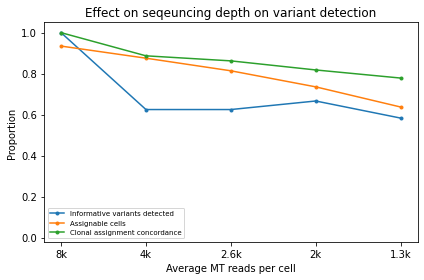

In [59]:
plt.plot(['8k', '4k', '2.6k','2k', '1.3k'],n_var, '-o', label="Informative variants detected", markersize=3)
plt.plot(['8k', '4k', '2.6k', '2k','1.3k'],assignable, '-o', label="Assignable cells", markersize=3)
plt.plot(['8k', '4k', '2.6k', '2k', '1.3k'],conc, '-o', label="Clonal assignment concordance", markersize=3)
plt.ylim([-0.02, 1.05])
plt.legend(loc = 'lower left', fontsize=7)
plt.ylabel('Proportion')
plt.xlabel('Average MT reads per cell')
plt.title('Effect on seqeuncing depth on variant detection')
#ax5.spines['right'].set_visible(False)
#ax5.spines['top'].set_visible(False)
plt.tight_layout()

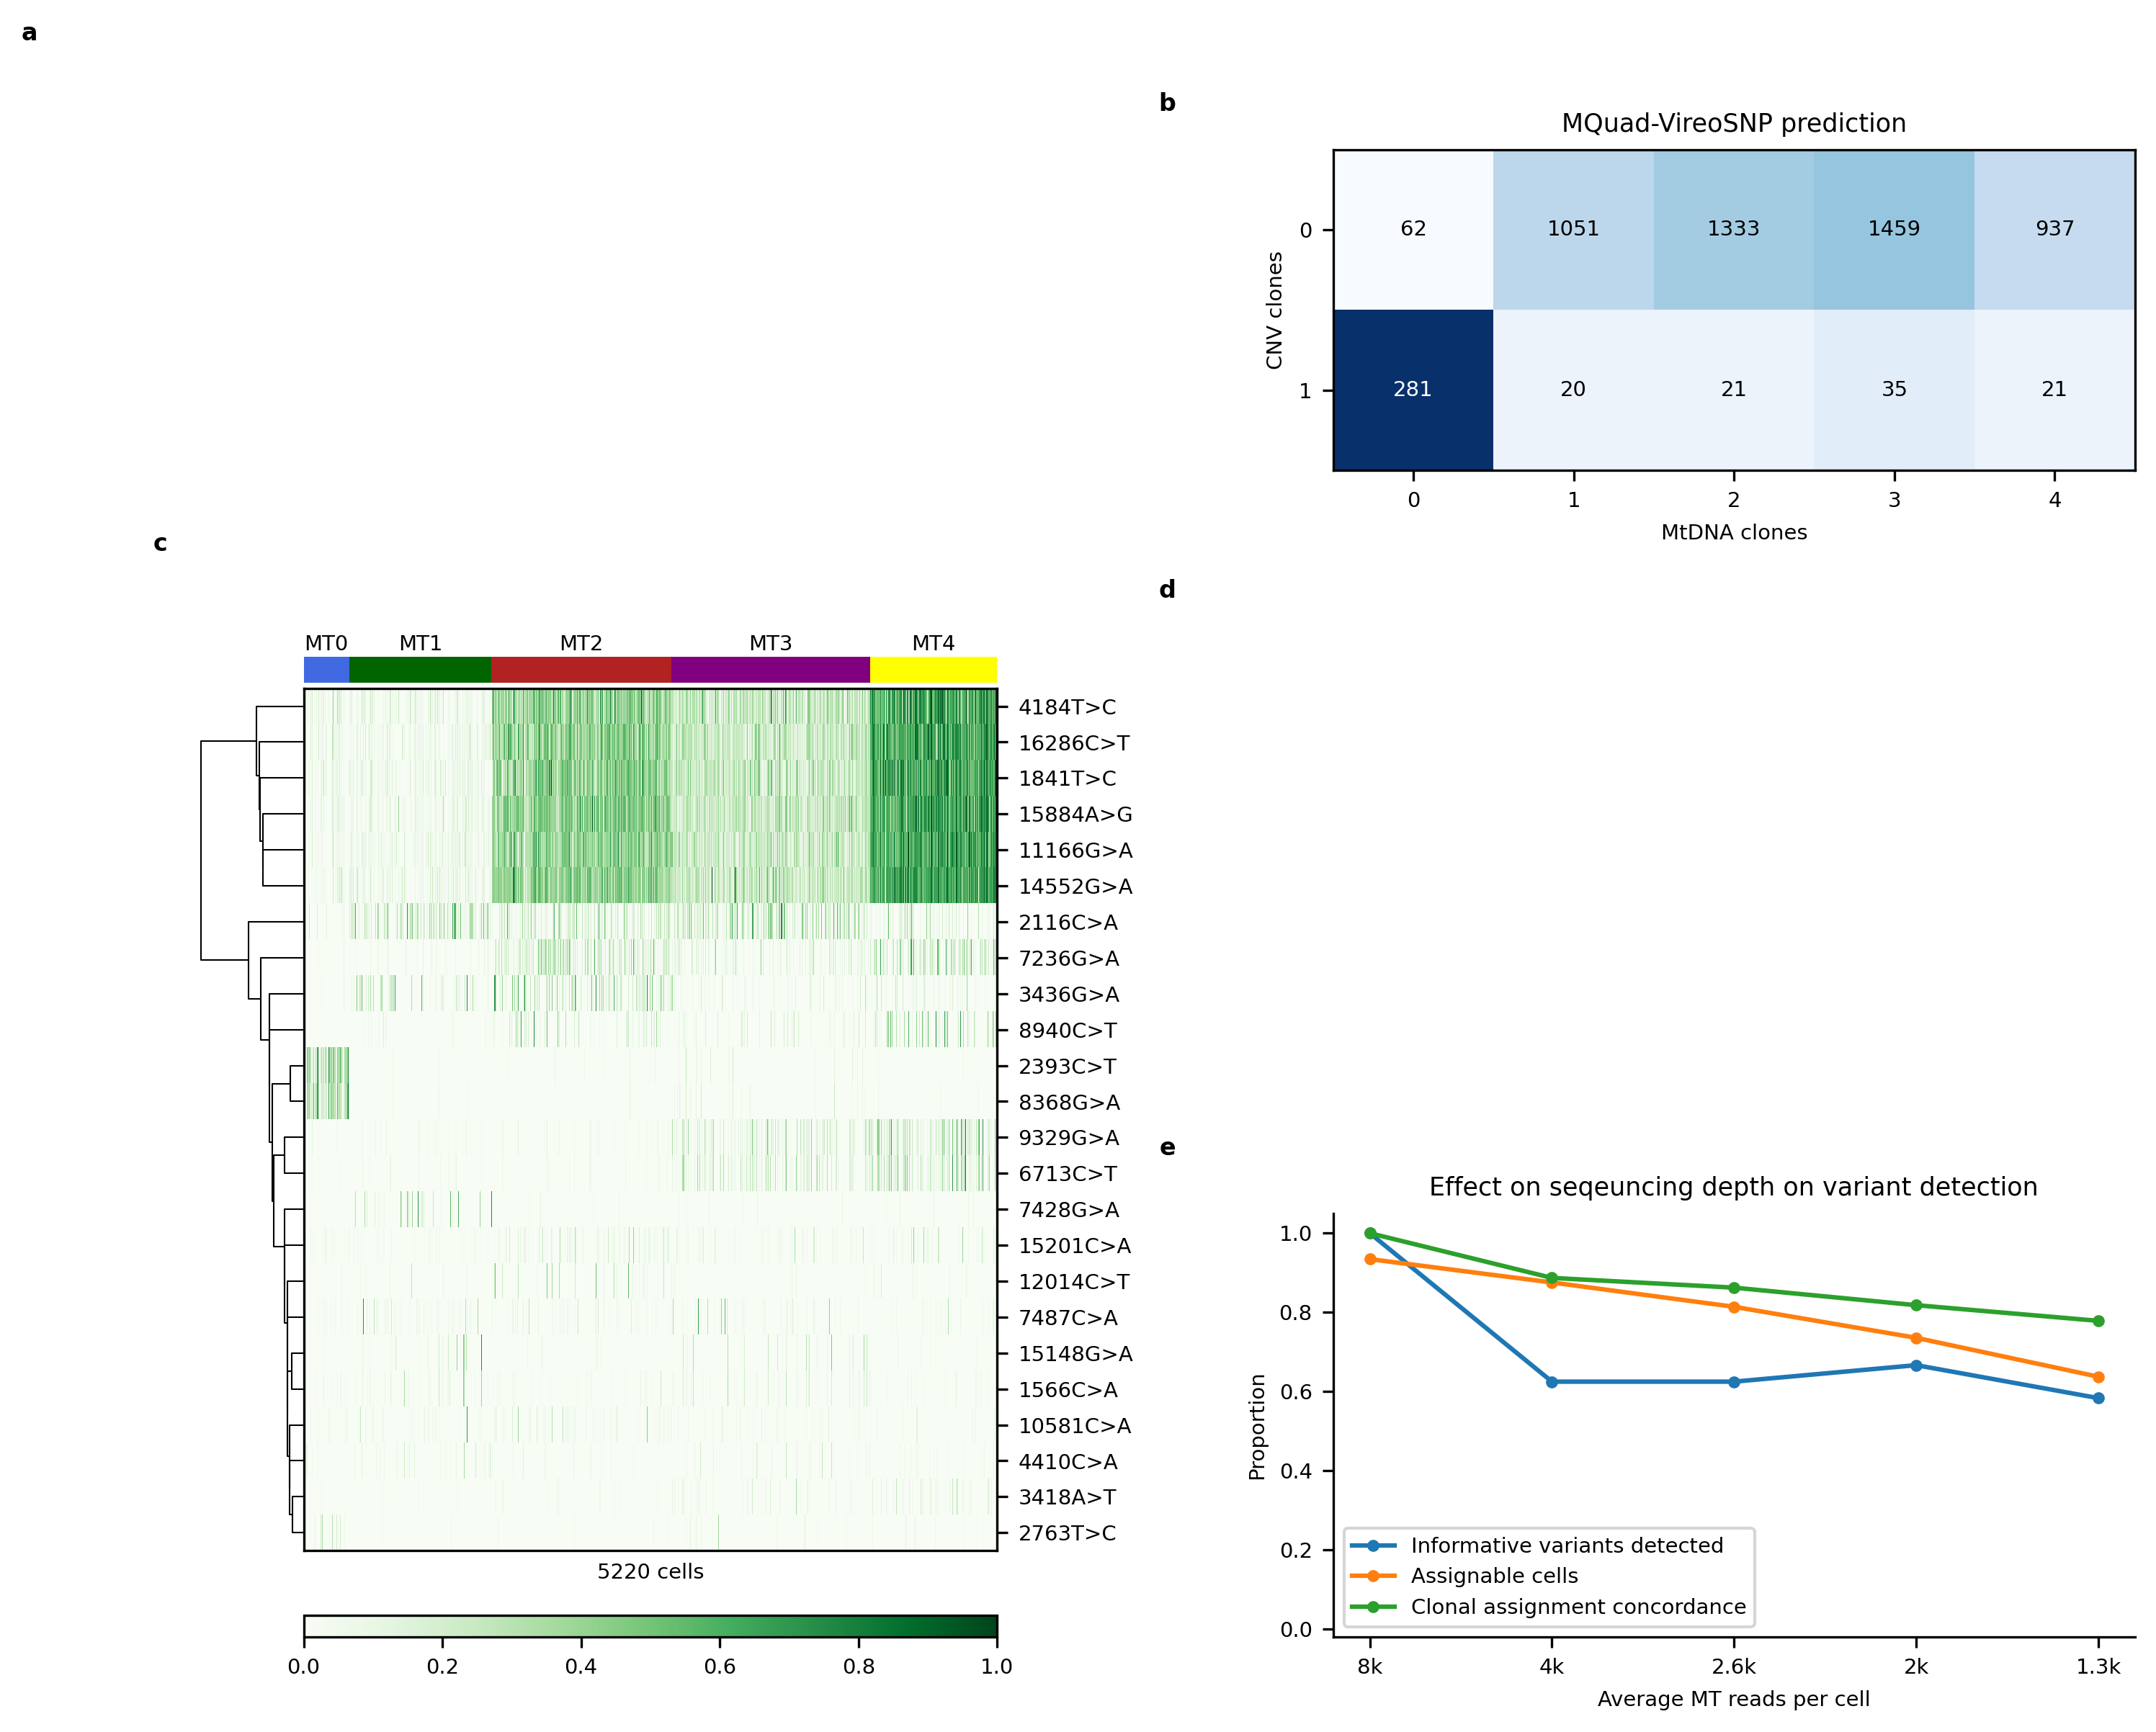

In [121]:
##put everything together
import matplotlib.gridspec as gridspec

plt.style.use('default')
font = {'family' : 'sans-serif',
        'size'   : 7}
plt.rc('font', **font)
cm = 1/2.54
fig = plt.figure(figsize=(10,8), dpi=300)

ax1 = plt.subplot2grid((3, 6), (0, 0), colspan=3)
ax1.text(-0.5*cm, 3*cm, 'a', transform = ax1.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
ax1.axis('off')

ax2 = plt.subplot2grid((3, 6), (0, 3), colspan=3)
ax2.text(-0.5*cm, 3*cm, 'b', transform = ax2.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
res = plot_confusionMatrix(confusion, ax2)
plt.title('MQuad-VireoSNP prediction')
plt.ylabel('CNV clones')
plt.xlabel('MtDNA clones')
plt.xticks(range(5), confusion.columns)
plt.yticks(range(len(confusion)), confusion.index)


ax3 = plt.subplot2grid((3, 6), (1, 0), colspan=3, rowspan=2)
ax3.text(-0.5*cm, 3*cm, 'c', transform = ax3.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
res = ax3.imshow(AF_df.iloc[row_idx, np.argsort(clone_id)], cmap='Greens', aspect='auto', interpolation='none')
ax3.xaxis.set_ticks([])
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position("right")
plt.xlabel('5220 cells')

plt.yticks(range(len(AF_df)), variants.iloc[row_idx][0], fontsize=7)

divider = make_axes_locatable(ax3)
left_ax = divider.append_axes("left", size=0.5, pad=0)
top_ax = divider.append_axes("top", size=0.13, pad=0.02, sharex=ax3)
bottom_ax = divider.append_axes("bottom", size=0.1, pad = 0.3)

plt.colorbar(res, cax = bottom_ax, orientation="horizontal", shrink=0.5)
#ax_t = fig.add_axes([0.026,0.07,0.07,0.55], frame_on=False)
with plt.rc_context({'lines.linewidth': 0.5}):
    d = dendrogram(linked, ax=left_ax, orientation='left', no_labels=True, color_threshold=0, link_color_func=lambda x: 'k')
left_ax.invert_yaxis()
left_ax.axis('off')

#top_ax = fig.add_axes([0.095, 0.65, 0.38, 0.03], frame_on=False)
#dont change label num
LEFT = 0
iicolor = 0
c_names = ['MT0', 'MT1', 'MT2', 'MT3', 'MT4']
label_num=np.bincount(clone_id)
clone_pal = ['royalblue', 'darkgreen', 'firebrick', 'purple', 'yellow']
for num in label_num:
        top_ax.barh(0,num+1,left=LEFT,color=clone_pal[iicolor])
        top_ax.text(x=LEFT + num/2, y=0.8, s=c_names[iicolor], va='center', ha='center')
        top_ax.set_xlim(0,5219)
        top_ax.axis('off')
        LEFT += num
        iicolor += 1

ax4 = plt.subplot2grid((3, 6), (1, 3), colspan=3)
ax4.text(-0.5*cm, 3*cm, 'd', transform = ax4.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')
ax4.axis('off')


ax5 = plt.subplot2grid((3, 6), (2, 3), colspan=3)
ax5.text(-0.5*cm, 3*cm, 'e', transform = ax5.transAxes, fontsize = 8, fontweight = 'bold', va='top', ha='right')

plt.plot(['8k', '4k', '2.6k','2k', '1.3k'],n_var, '-o', label="Informative variants detected", markersize=3)
plt.plot(['8k', '4k', '2.6k', '2k','1.3k'],assignable, '-o', label="Assignable cells", markersize=3)
plt.plot(['8k', '4k', '2.6k', '2k', '1.3k'],conc, '-o', label="Clonal assignment concordance", markersize=3)
plt.ylim([-0.02, 1.05])
plt.legend(loc = 'lower left', fontsize=7)
plt.ylabel('Proportion')
plt.xlabel('Average MT reads per cell')
plt.title('Effect on seqeuncing depth on variant detection')
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
plt.tight_layout()

plt.savefig('figure4.pdf')